In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import LineList
from scipy.special import exp1
from physical_constants import *
from interpolator import get_interpolated_cross_sections
from ariel_wavelengths import ariel_wavelengths

In [9]:
opacity_data_path = '../line_lists'

# get all files in the directory which end with .h5
line_list_paths = [f for f in os.listdir(opacity_data_path) if f.endswith('.h5')]

absorbers = [LineList(os.path.join(opacity_data_path, f)) for f in line_list_paths]

# Assert that all absorbers have the same wavelengths
for i in range(len(absorbers)-1):
    assert np.array_equal(absorbers[i].wavelengths, absorbers[i+1].wavelengths), \
        f"Wavelengths of {absorbers[i].name} and {absorbers[i+1].name} do not match."
        
# Since they are the same, get the wavelengths from the first absorber
wavelengths = absorbers[0].wavelengths

# # IDK if this is needed:
# # Assert that all the temperature grids and pressure grids are the same
# for i in range(len(absorbers)-1):
#     assert np.array_equal(absorbers[i].pressures, absorbers[i+1].pressures)
#     assert np.array_equal(absorbers[i].temperatures, absorbers[i+1].temperatures)

# # Since they are the same, get the pressure and temperature grids from the first absorber
# temp_grid = absorbers[0].temperatures
# pressure_grid = absorbers[0].pressures

Reading in CO2
Reading in CO
Reading in NH3
Reading in CH4
Reading in H2O


### Define the Heng Model:

In [11]:
def get_m_bar(concentrations):
    """
    Calculate the mean molecular mass of the atmosphere.
    concentrations: list of absolute concentrations of each absorber

    We include the contribution of H2 and He in the mean molecular mass, 
    which are assumed to have a relative concentration of 0.17 which gives a mean molecular mass of 2.34

    Returns the mean molecular mass in amu.
    """

    # Start with the contribution of H2 and He
    mbar = (1 - np.sum(concentrations)) * 2.34

    # Add the contributions to the mass from each absorber
    for i, concentration in enumerate(concentrations):
        mbar += concentration * absorbers[i].molecular_mass

    return mbar


def get_kappa(concentrations, temperature, pressure):
    """
    The chis are the opacities which are the cross sections in cm²/molecule 

    We return kappa in m²/kg
    """

    m_bar = get_m_bar(concentrations) # in amu
    m_bar_kg = m_bar * mamu # in kg

    kappa = np.zeros(len(wavelengths))
    for concentration, absorber in zip(concentrations, absorbers):
        molecular_mass_kg = absorber.molecular_mass * mamu # in kg
        chi = get_interpolated_cross_sections(pressure, temperature, absorber) # in cm²/molecule
        chi_meters = chi * 1e-4 # in m²/molecule
        chi_SI = chi_meters / molecular_mass_kg # in m²/kg # Allegedly this is the correct way to do it???
        kappa += concentration * molecular_mass_kg * chi_SI / m_bar_kg

    return kappa


def compute_scale_height(T, g, concentrations):
    """
    Compute the scale height of the atmosphere, given:
    - T: temperature in Kelvin
    - g: gravitational acceleration in m/s^2
    - concentrations: relative abundances of the species in the atmosphere (these are used to compute the mean molecular weight)
    
    Retrurns the scale height in meters!
    """
    m_bar = get_m_bar(concentrations)  # mean molecular weight in amu
    m = m_bar * mamu  # convert mean molecular weight to kg
    return (k_B * T) / (m * g)


def get_tau(concentrations, temperature, pressure, planet_radius, g):
    """
    Calculate the optical depth of the atmosphere.
    """
    # kappa = get_kappa(concentrations, temperature, pressure) # in cm²/molecule
    kappa = get_kappa(concentrations, temperature, pressure) # in m²/kg
    H = compute_scale_height(temperature, g, concentrations) # In meters
    pressure_SI = pressure * 1e5  # Convert pressure from atm to Pa
    tau = (pressure_SI * kappa / g) * np.sqrt(2 * np.pi * planet_radius / H)
    return tau   # Which is dimensionless!


def compute_scale_height(T, g, concentrations):
    """
    Compute the scale height of the atmosphere, given:
    - T: temperature in Kelvin
    - g: gravitational acceleration in m/s^2
    - concentrations: relative abundances of the species in the atmosphere (these are used to compute the mean molecular weight)
    
    Retrurns the scale height in meters!
    """
    m_bar = get_m_bar(concentrations)  # mean molecular weight in amu
    m = m_bar * mamu  # convert mean molecular weight to kg
    return (k_B * T) / (m * g)


def get_tau(concentrations, temperature, pressure, planet_radius, g):
    """
    Calculate the optical depth of the atmosphere.
    """
    # kappa = get_kappa(concentrations, temperature, pressure) # in cm²/molecule
    kappa = get_kappa(concentrations, temperature, pressure) # in m²/kg
    H = compute_scale_height(temperature, g, concentrations) # In meters
    pressure_SI = pressure * 1e5  # Convert pressure from atm to Pa
    tau = (pressure_SI * kappa / g) * np.sqrt(2 * np.pi * planet_radius / H)
    return tau   # Which is dimensionless!


def compute_modulation(concentrations, temperature, pressure, planet_radius, star_radius, g):
    """
    Compute the modulation of the light curve due to the atmosphere.
    """
    tau = get_tau(concentrations, temperature, pressure, planet_radius, g)
    H = compute_scale_height(temperature, g, concentrations)
    first_term = planet_radius / star_radius
    second_term = (H / star_radius) * (gamma + np.log(tau) + exp1(tau))
    return first_term + second_term

Text(0.5, 1.0, 'High Resolution Modulation')

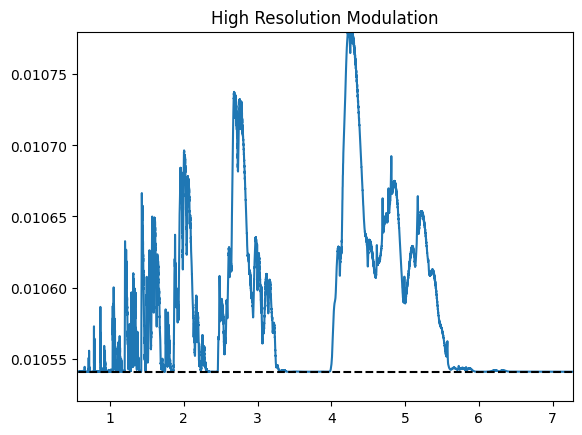

In [12]:
### Parameters for the planet and star:
concentrations = [0.01, 0.0, 0.0, 0.0]  # relative abundances of the species
temperature = 300  # temperature in Kelvin
pressure = 10 # pressure in bars!
planet_radius = RJ  # radius of the planet in meters
star_radius = Rsun  # radius of the star in meters
planet_mass = MJ    # mass of the planet in kg
# g = g_earth  # gravitational acceleration in m/s^2
g = Gnewton * planet_mass / (planet_radius**2)  # gravitational acceleration at the surface of the planet

### Compute the modulation:
root_modulation = compute_modulation(concentrations, temperature, pressure, planet_radius, star_radius, g)
modulation = root_modulation**2

plt.plot(wavelengths, modulation, label='PyREx')
plt.hlines((planet_radius/star_radius)**2, wavelengths[0], wavelengths[-1], color='black', linestyle='--')
# print(f'STD: {np.std(modulation)}')
plt.xlim(ariel_wavelengths[0], ariel_wavelengths[-1])
plt.ylim(0.01052, 0.01078)
plt.title('High Resolution Modulation')